In [1]:
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
from PIL import Image
import trackpy as tp
from scipy.spatial.distance import pdist

In [2]:
def see_slice(image, positions, s, radius, axis=2, sizes=(10, 8)):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    to_show = np.moveaxis(image, axis, 0)
    ax.imshow(to_show[s].T)
    if axis == -1:
        axis = 2
    shown_axes = np.array([i for i in range(3) if i != axis])
    for p in positions:
        x, y = p[shown_axes]
        z = p[axis]
        dz = abs(z - s)
        if z > s:
            color='k'
        else:
            color='w'
        if dz < radius:
            r_slice = np.sqrt(radius**2 - dz**2)
            circle = plt.Circle([x, y], radius=r_slice, color=color, fill=None, lw=2)
            ax.add_patch(circle)
    fig.set_size_inches(sizes[0], sizes[1])
    plt.axis('off')
    plt.show()

def get_gr(positions, cutoff, bins, minimum_gas_number=1e4):
    bins = np.linspace(0, cutoff, bins)
    drs = bins[1:] - bins[:-1]
    distances = pdist(positions).ravel()
    if positions.shape[0] < minimum_gas_number:
        rg_hists = []
        for i in range(int(minimum_gas_number) // positions.shape[0] + 2):
            random_gas = np.random.random(positions.shape) * np.array([positions.max(axis=0)])
            rg_hist = np.histogram(pdist(random_gas), bins=bins)[0]
            rg_hists.append(rg_hist)
        rg_hist = np.mean(rg_hists, 0)
    else:
        random_gas = np.random.random(positions.shape) * np.array([positions.max(axis=0)])
        rg_hist = np.histogram(pdist(random_gas), bins=bins)[0]
    hist = np.histogram(distances, bins=bins)[0]
    hist = hist / rg_hist
    hist[np.isnan(hist)] = 0
    centres = (bins[1:] + bins[:-1]) / 2
    return centres, hist

# Load data from tif as a numpy array

In [7]:
tiff_img = Image.open("deconvolutionseriesDec19-Mar20.lif - 0_45-newnewgood2-1.tif")
img = []
for z in range(tiff_img.n_frames):
    tiff_img.seek(z)
    data = tiff_img.convert('L')
    img.append(np.array(data))
img = np.array(img)
img = np.moveaxis(img, 0, -1)
print(img.shape)

(512, 512, 135)


# Use Trackpy to locate

In [22]:
#smoothed = ndimage.gaussian_filter(img, 4)
smoothes = img.copy()
features = tp.locate(smoothed, 11)

In [23]:
xyz = np.array(features).T[:3]

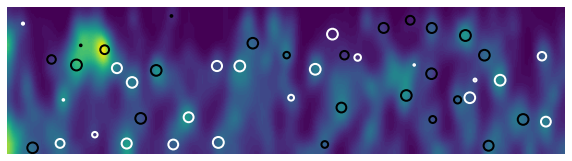

In [24]:
see_slice(smoothed, xyz.T, s=50, radius=5, axis=1)

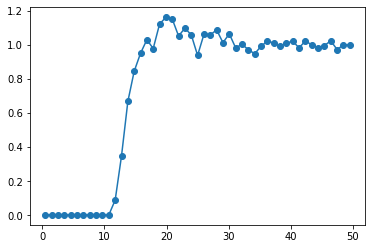

In [25]:
gr = get_gr(xyz.T, 50, 50)
plt.plot(*gr, '-o')
plt.show()

# Magic Filter

In [26]:
import read_lif
import matplotlib.pyplot as plt
import numpy as np
import yaggie
from analysis import get_gr, get_gr_inbox
import measure
from scipy import ndimage
from scipy import signal

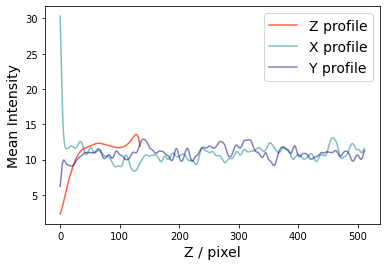

In [27]:
image = img.copy()
plt.plot(image.mean(0).mean(0), color='tomato', label='Z profile')
plt.plot(image.mean(2).mean(1), color='teal', label='X profile', alpha=0.5)
plt.plot(image.mean(2).mean(0), color='navy', label='Y profile', alpha=0.5)
plt.xlabel('Z / pixel', fontsize=14)
plt.ylabel('Mean Intensity', fontsize=14)
plt.legend(fontsize=14)
plt.show()

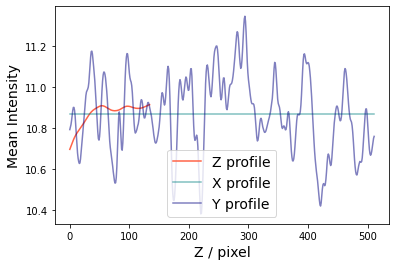

In [28]:
fix_y = image / np.reshape( image.mean(2).mean(0), (1, image.shape[1], 1) )

fix_z = fix_y / np.reshape( fix_y.mean(0).mean(0), (1, 1, image.shape[2]) )

fix_x = fix_z / np.reshape( fix_z.mean(-1).mean(-1), (image.shape[0], 1, 1) )

fix_x = fix_x / fix_x.max() * 255

plt.plot(fix_x.mean(0).mean(0), color='tomato', label='Z profile')
plt.plot(fix_x.mean(2).mean(1), color='teal', label='X profile', alpha=0.5)
plt.plot(fix_x.mean(2).mean(0), color='navy', label='Y profile', alpha=0.5)
plt.xlabel('Z / pixel', fontsize=14)
plt.ylabel('Mean Intensity', fontsize=14)
plt.legend(fontsize=14)
np.save('image', fix_x)
plt.show()

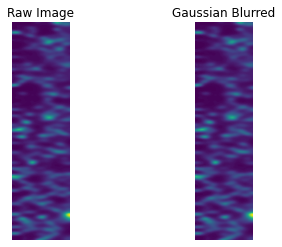

In [132]:
roi = tuple([slice(0, 512), slice(0, 512), slice(0, None)])
small = fix_x[roi]
blurred = small.copy()#ndimage.gaussian_filter(small, 3)

x = 50
plt.subplot(121).imshow(small[x])
plt.title("Raw Image")
plt.axis('off')
plt.subplot(122).imshow(blurred[x])
plt.title('Gaussian Blurred')
plt.axis('off')
plt.show()

In [133]:
features = tp.locate(blurred, 11)
xyz = np.array(features).T[:3]

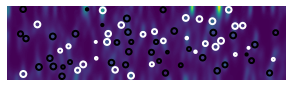

(3585, 9)


In [134]:
see_slice(small, xyz.T, 30, 5.5, axis=1, sizes=(5, 5))
print(features.shape)

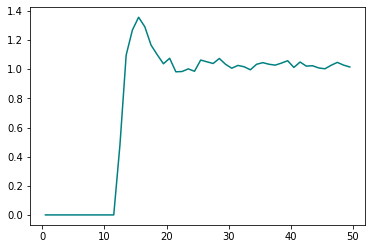

In [135]:
gr = get_gr(xyz.T, 50, 51, 1e4)
plt.plot(*gr, color='teal')
plt.show()

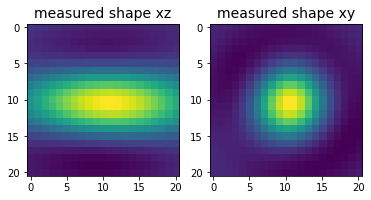

Shape of particle shape array is (21, 21, 21)


In [136]:
radius = 10
shape = measure.measure_shape_3d(small, xyz.T, radius)
shape = shape / shape.max()
plt.subplot(121).imshow(shape.mean(0))
plt.title('measured shape xz', fontsize=14)
plt.subplot(122).imshow(shape.mean(-1))
plt.title('measured shape xy', fontsize=14)
plt.show()
print('Shape of particle shape array is', shape.shape)

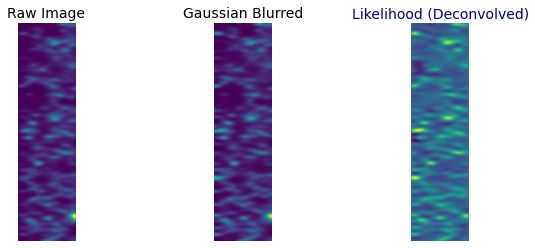

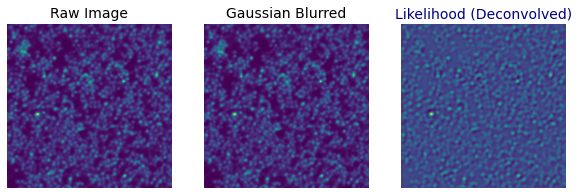

In [137]:
for_corr = small.copy()
s1 = (for_corr - for_corr.mean()) / for_corr.std()
s2 = (shape - shape.mean()) / shape.std()
f = signal.correlate(s1, s2, mode='same')

x = 50
plt.subplot(131).imshow(image[roi][x])
plt.title("Raw Image", fontsize=14)
plt.axis('off')
plt.subplot(132).imshow(small[x])
plt.title("Gaussian Blurred", fontsize=14)
plt.axis('off')
plt.subplot(133).imshow(f[x])
plt.title("Likelihood (Deconvolved)", fontsize=14, color='navy')
plt.axis('off')
plt.gcf().set_size_inches(10, 4)
plt.show()
plt.subplot(131).imshow(fix_x[roi][:, :, x])
plt.title("Raw Image", fontsize=14)
plt.axis('off')
plt.subplot(132).imshow(small[:, :, x])
plt.title("Gaussian Blurred", fontsize=14)
plt.axis('off')
plt.subplot(133).imshow(f[:, :, x])
plt.title("Likelihood (Deconvolved)", fontsize=14, color='navy')
plt.axis('off')
plt.gcf().set_size_inches(10, 4)
plt.show()

(3, 3897)


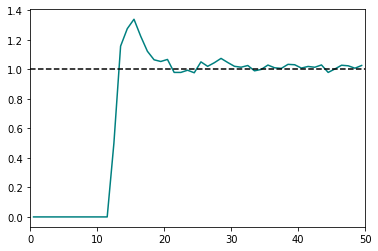

In [138]:
features = tp.locate(blurred, 11, percentile=0)
xyz = np.array(features).T[:3]
print(xyz.shape)
gr = get_gr(xyz.T, 50, 51, 1e4)
plt.plot(*gr, color='teal')
plt.plot((0, 50), (1, 1), color='k', ls='--')
plt.xlim(0, 50)
plt.show()

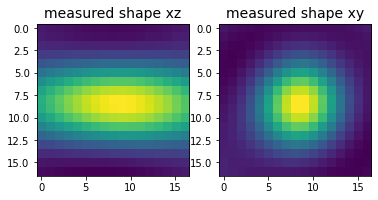

(3, 1761)


In [139]:
r_xy, r_z = 8, 8
s_xy = slice(r_z - r_xy, r_z + r_xy + 1)
shape = measure.measure_shape_3d(small, xyz.T, r_z)
shape = shape[s_xy, s_xy, :] 
plt.subplot(121).imshow(shape.mean(0))
plt.title('measured shape xz', fontsize=14)
plt.subplot(122).imshow(shape.mean(-1))
plt.title('measured shape xy', fontsize=14)
plt.show()

for_corr = small.copy()
s1 = (for_corr - for_corr.mean()) / for_corr.std()
s2 = (shape - shape.mean()) / shape.std()
f = signal.correlate(s1, s2, mode='valid')

cc_features = tp.locate(f, 11, percentile=90)
xyz = np.array(cc_features).T[:3]
xyz += (np.array(s2.shape) / 2)[:, None]
print(xyz.shape)

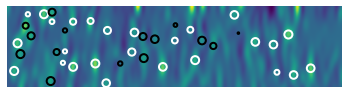

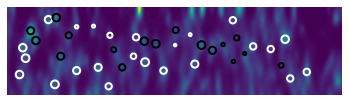

In [140]:
s = 20
axis = 1
see_slice(f, (xyz - (np.array(s2.shape)/2)[:, None]).T, s-10, 6, axis=axis, sizes=(6, 6))
see_slice(small, xyz.T, s, 6, axis=axis, sizes=(6, 6))

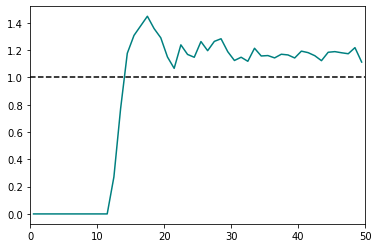

In [141]:
gr = get_gr(xyz.T, 50, 51, 1e4)
plt.plot(*gr, color='teal')
plt.plot((0, 50), (1, 1), color='k', ls='--')
plt.xlim(0, 50)
plt.show()